<a href="https://colab.research.google.com/github/JacksonLeb/tensorflow_learning/blob/main/06_transfer_learning_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Scaling Up to 101 Image Classes from Food101

In [1]:
#Check to see if we're using a GPU
!nvidia-smi

Mon Jul 18 00:20:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8    13W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##Creating helper functions

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-07-18 00:20:49--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-07-18 00:20:49 (107 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
#importing helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

##101 food classes: working with less data

In [4]:
#downloading data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

--2022-07-18 00:20:55--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.16.128, 172.217.12.240, 142.250.81.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.16.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   151MB/s    in 12s     

2022-07-18 00:21:07 (132 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [6]:
#how many image classses are there
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/red_velvet_cake'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cannoli'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/strawberry_shortcake'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/mussels'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pulled_pork_sandwich'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/spring_rolls'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pork_chop'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/spaghetti_carbonara'.
There are 0 directorie

In [7]:
#setup data inputs
import tensorflow as tf
IMG_SIZE = (244, 244)


train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE,
                                                                shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


#training our big model on 10 percent of food 101

In [9]:
#create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_best_only=True,
                                                         monitor="val_accuracy",
                                                         save_weights_only=True)

In [15]:
#Create data augmentation layer to incorprorate right into model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential


#set up data aug
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  #preprocessing.Rescale(1/255.) dont need to, already rescaled in efficient net
], name="data_augmentation")

In [17]:
#set up base model and freeze all base model layers (to start)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

#set up model architecture with trainable top layers
inputs = layers.Input(shape=(244,244,3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False) #weights in base model stay frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 244, 244, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 244, 244, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [20]:
#compile 
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

#fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           steps_per_epoch=len(train_data_all_10_percent),
                                           validation_data=test_data,
                                           validation_steps=int(0.15*len(test_data)),
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 112s 404ms/step - loss: 3.4562 - accuracy: 0.2507 - val_loss: 2.6769 - val_accuracy: 0.4010
Epoch 2/5
237/237 [==============================] - 75s 315ms/step - loss: 2.3231 - accuracy: 0.4668 - val_loss: 2.2292 - val_accuracy: 0.4587
Epoch 3/5
237/237 [==============================] - 69s 289ms/step - loss: 1.9504 - accuracy: 0.5373 - val_loss: 2.0416 - val_accuracy: 0.4910
Epoch 4/5
237/237 [==============================] - 63s 264ms/step - loss: 1.7299 - accuracy: 0.5852 - val_loss: 1.9795 - val_accuracy: 0.4876
Epoch 5/5
237/237 [==============================] - 63s 264ms/step - loss: 1.5634 - accuracy: 0.6220 - val_loss: 1.9076 - val_accuracy: 0.5079


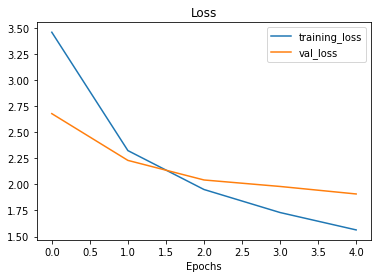

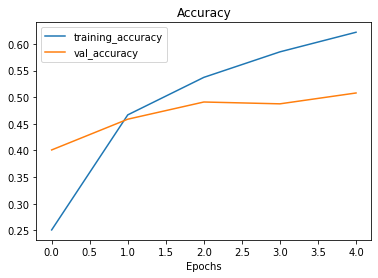

In [21]:
plot_loss_curves(history_all_classes_10_percent)

##fine Tuning

In [22]:
base_model.trainable = True

for layer in base_model.layers[:-5]:
  layer.trainable = False

In [23]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_1 (Rescaling)        (None, None, None,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_1 (Normalization  (None, None, None,   7          ['rescaling_1[0][0]']            
 )                              3)                                                   

In [24]:
#recompile model with lower learning rate
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              metrics=["accuracy"])


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [25]:
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [26]:
for layer in model.layers[2].layers:
  print(layer.name, layer.trainable)

input_2 False
rescaling_1 False
normalization_1 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
block2b_project_conv False

In [28]:
fine_tune_epochs = 10 #total num of epochs = initial + fine tuning

#fine tuning our model
history_all_classes_10_percent_fine_tuning = model.fit(train_data_all_10_percent,
                                                       epochs=fine_tune_epochs,
                                                       validation_data=test_data,
                                                       validation_steps=int(0.15 * len(test_data)),
                                                       initial_epoch = history_all_classes_10_percent.epoch[-1],)


Epoch 5/10
237/237 [==============================] - 66s 253ms/step - loss: 1.3334 - accuracy: 0.6535 - val_loss: 1.9015 - val_accuracy: 0.5058
Epoch 6/10
237/237 [==============================] - 53s 222ms/step - loss: 1.2014 - accuracy: 0.6750 - val_loss: 1.8785 - val_accuracy: 0.5172
Epoch 7/10
237/237 [==============================] - 53s 221ms/step - loss: 1.1262 - accuracy: 0.6965 - val_loss: 1.8727 - val_accuracy: 0.5209
Epoch 8/10
237/237 [==============================] - 51s 212ms/step - loss: 1.0597 - accuracy: 0.7162 - val_loss: 1.8618 - val_accuracy: 0.5199
Epoch 9/10
237/237 [==============================] - 48s 201ms/step - loss: 0.9952 - accuracy: 0.7380 - val_loss: 1.8663 - val_accuracy: 0.5225
Epoch 10/10
237/237 [==============================] - 47s 197ms/step - loss: 0.9350 - accuracy: 0.7530 - val_loss: 1.8488 - val_accuracy: 0.5230


In [29]:
#Evaluate on the whole test data
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 66s 84ms/step - loss: 1.5548 - accuracy: 0.5931


[1.5548362731933594, 0.5931088924407959]

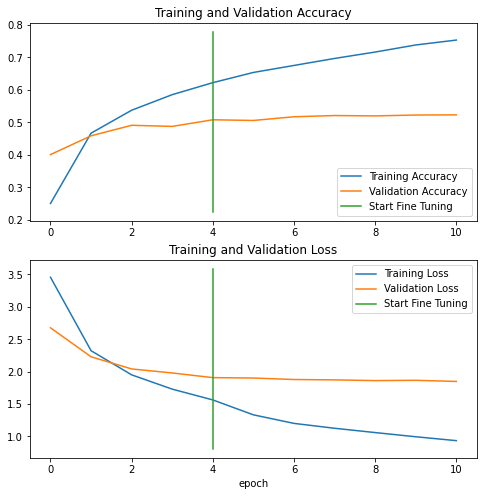

In [30]:
#compare historys
compare_historys(original_history = history_all_classes_10_percent,
                 new_history = history_all_classes_10_percent_fine_tuning)

In [31]:
#Saving and Loading our trained model
model.save("101_food_classes_10_percent_saved_big_model_fine_tuned")

INFO:tensorflow:Assets written to: 101_food_classes_10_percent_saved_big_model_fine_tuned/assets


In [32]:
load_model = tf.keras.models.load_model("101_food_classes_10_percent_saved_big_model_fine_tuned")

In [34]:
loaded_models_results = load_model.evaluate(test_data)
loaded_models_results
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 67s 83ms/step - loss: 1.5548 - accuracy: 0.5931


[1.5548362731933594, 0.5931088924407959]